In [26]:
import os
while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis':
    os.chdir('..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [27]:
import pickle
import decoupler
import pandas as pd
import matplotlib.pyplot as plt

## On deseq results

In [28]:
with open('results/task9_deseq_results.pkl', 'rb') as f:
    deseq_results = pickle.load(f)

In [29]:
progeny = decoupler.get_progeny(top=5000)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
69995,p53,RGS9BP,0.842450,4.088961e-02
69996,p53,IRAG1,0.807761,4.089827e-02
69997,p53,ATP2B1,-2.320707,4.089862e-02
69998,p53,SNX29,0.985361,4.091074e-02


16227 features of mat are empty, they will be removed.
Running consensus.
Running mlm on mat with 1 samples and 1433 targets for 14 sources.
Running ulm on mat with 1 samples and 1433 targets for 14 sources.
Running wsum on mat with 1 samples and 1433 targets for 14 sources.
     Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT      MAPK      NFkB  \
pre  0.821229 -0.073737  1.925974  0.594688 -1.681275  1.334855 -0.043518   

         PI3K      TGFb      TNFa     Trail      VEGF       WNT       p53  
pre -0.396161  0.484932  0.135768 -0.960588  0.553075 -1.303386 -0.044275  
     Androgen     EGFR  Estrogen   Hypoxia  JAK-STAT      MAPK      NFkB  \
pre  0.411516  0.94122  0.054108  0.552052   0.09271  0.181924  0.965288   

         PI3K      TGFb      TNFa    Trail      VEGF       WNT       p53  
pre  0.691986  0.627724  0.892005  0.33676  0.580212  0.192443  0.964685  
14525 features of mat are empty, they will be removed.
Running consensus.
Running mlm on mat with 1 samples and 24

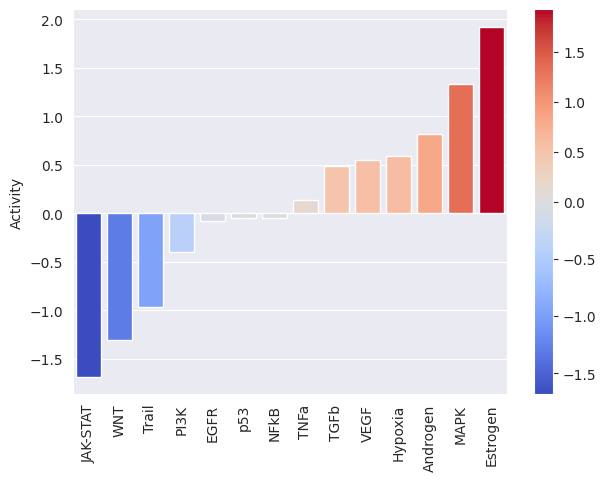

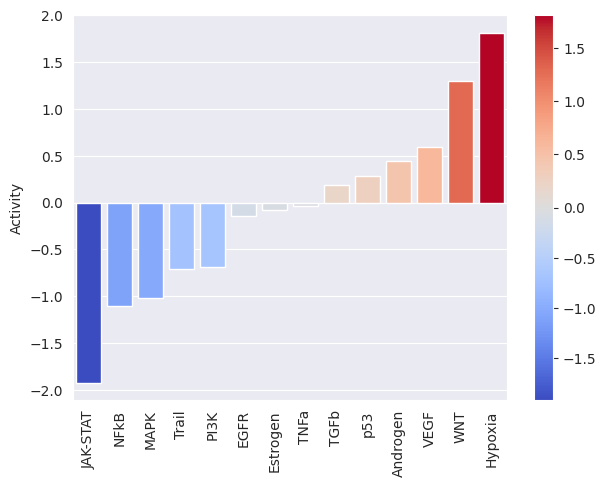

In [30]:

mat_pre = pd.DataFrame([deseq_results['pre']["stat"]], index=['pre'])
mat_post = pd.DataFrame([deseq_results['post']["stat"]], index=['post'])


pathway_acts, pathway_pvals = decoupler.run_consensus(mat=mat_pre, net=progeny, verbose=True)
decoupler.plot_barplot(pathway_acts, 'pre', top=50, vertical=False)

print(pathway_acts)
print(pathway_pvals)

pathway_acts, pathway_pvals = decoupler.run_consensus(mat=mat_post, net=progeny, verbose=True)
decoupler.plot_barplot(pathway_acts, 'post', top=50, vertical=False)

print(pathway_acts)
print(pathway_pvals)


## Progeny on logTPM's

In [31]:
ann = pd.read_csv('data/ann.csv', index_col=0).rename(columns={'treatment response': 'treatment_response'})
pre_ann = ann[(ann['time point'] == 'pre-treatment') & (ann['treatment_response'] != 'unknown')]
post_ann = ann[ann['time point'] == 'post-treatment']

log_tpms = pd.read_csv('data/log_tpms_from_fpkm_hgnc_filtered_by_ann.csv', index_col=0)
pre_log_tpms = log_tpms.loc[pre_ann.index]
post_log_tpms = log_tpms.loc[post_ann.index]

pre_log_tpms.shape

(25, 19388)

In [32]:
progeny = decoupler.get_progeny(top=5000)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
69995,p53,RGS9BP,0.842450,4.088961e-02
69996,p53,IRAG1,0.807761,4.089827e-02
69997,p53,ATP2B1,-2.320707,4.089862e-02
69998,p53,SNX29,0.985361,4.091074e-02


In [33]:
from notebooks.tasks58.scaling import median_scaling
from notebooks.tasks58.plots import plot_correlations
import seaborn as sns

def process(kind='pre'):
    if kind == 'pre':
        log_tpm = pre_log_tpms
    else:
        log_tpm = post_log_tpms
    
    pathway_acts, pathway_pvals = decoupler.run_consensus(mat=log_tpm, net=progeny, verbose=True)
    pathway_pvals = pathway_pvals.rename(columns={col: 'p_' + col for col in pathway_pvals})
    pathway_acts = pathway_acts.rename(columns={col: 'a_' + col for col in pathway_acts})
    pathways = pathway_acts.merge(pathway_pvals, left_index=True, right_index=True)
    ssgsea_df = pd.read_csv(f'data/{kind}_ssgsea_expr_ann.csv', index_col=0)
    df = ssgsea_df.merge(pathways, left_index=True, right_index=True)
    
    cols = ['a_MAPK', 'a_PI3K'] + ['emt_bg_med', 'emt_budinska_med'] + ['MET']
    corr = df[cols].corr()
    plt.figure(figsize=(8, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    plt.title(f'Correlations on {kind}-treatment samples')

336 features of mat are empty, they will be removed.
Running consensus.
Running mlm on mat with 25 samples and 19052 targets for 14 sources.
Running ulm on mat with 25 samples and 19052 targets for 14 sources.
Running wsum on mat with 25 samples and 19052 targets for 14 sources.


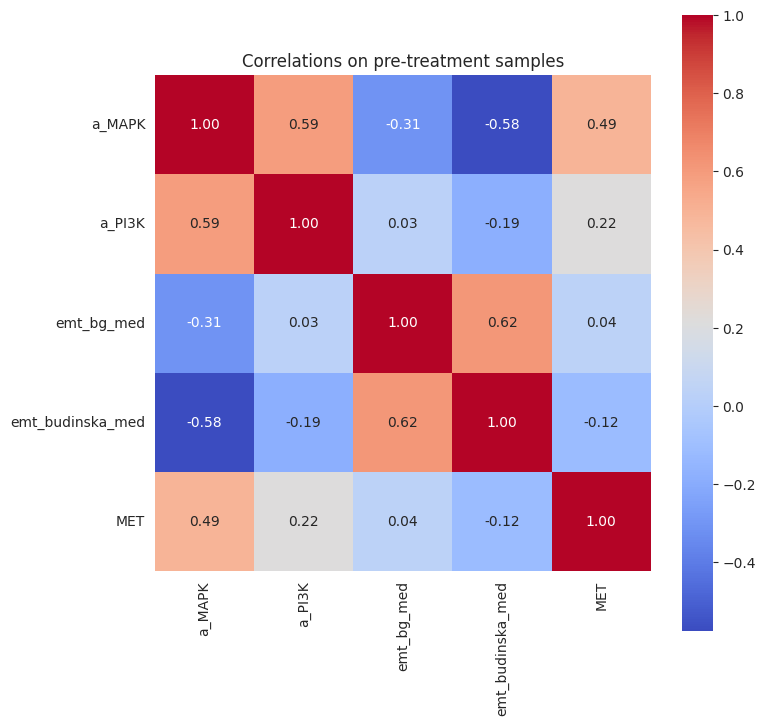

In [34]:
process('pre')

772 features of mat are empty, they will be removed.
Running consensus.
Running mlm on mat with 13 samples and 18616 targets for 14 sources.
Running ulm on mat with 13 samples and 18616 targets for 14 sources.
Running wsum on mat with 13 samples and 18616 targets for 14 sources.


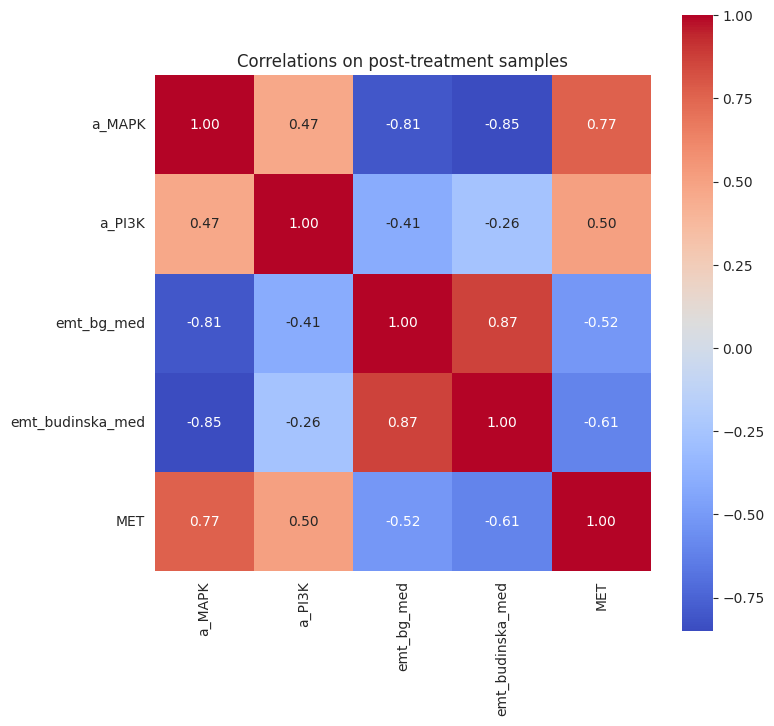

In [35]:
process('post')